This notebook will generate a few plots useful to demonstrating the agreement between the SIR ODE's and the nSIR model in some limited cases where the ODE's hold. Most of this code is simply from other files.

In [84]:
# ODE

import SIR_model as sir
import network_manipulation as nm
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
import random
import time
import network_stats as ns

dataset_paths = [
'Sociopatterns datasets/conference_2009.dat_',
'Sociopatterns datasets/highschool_2011.csv',
'Sociopatterns datasets/highschool_2012.csv',
'Sociopatterns datasets/highschool_2013.csv',
'Sociopatterns datasets/hospital_2010.dat_',
'Sociopatterns datasets/primaryschool_2014.csv',
'Sociopatterns datasets/workplace_2013.dat',
'Sociopatterns datasets/workplace_2015.dat_']

dataset_names = [
    'Conference 1', 
    'Highschool 1', 
    'Highschool 2', 
    'Highschool 3', 
    'Hospital 1', 
    'Primaryschool 1', 
    'Workplace 1', 
    'Workplace 2']

simulation_params = {}
simulation_params['Time'] = 100
simulation_params['Runs'] = 25
simulation_params['Initial'] = 0.05
simulation_params['Beta'] = 0.8
simulation_params['Gamma'] = 0.2
simulation_params['Threshold'] = 65*2 # only affects simulation

original_beta = simulation_params['Beta']
connectivity = 0.1

G = nm.build_nxgraph(dataset_paths[3], False) # un-normalised weighted networkx graph
N = len(G) 

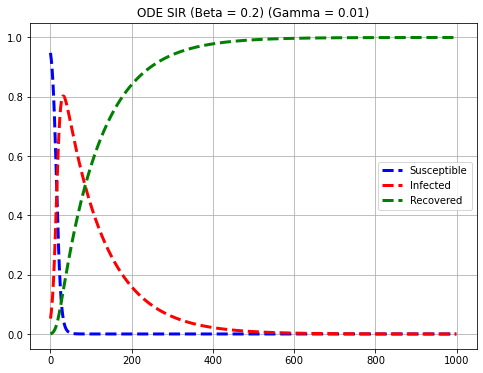

In [81]:
# ODE
plt.figure(figsize=(8, 6))
plt.grid()
simulation_params['Beta'] = 0.2
simulation_params['Gamma'] = 0.01
simulation_params['Time'] = 1000
analytic_time = np.arange(0, simulation_params['Time'])
S, I, R = sir.analytic_sol(G, simulation_params)

plt.plot(analytic_time, S, linewidth = 3, label = 'Susceptible', color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(analytic_time, I, linewidth = 3, label = 'Infected', color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(analytic_time, R, linewidth = 3, label = 'Recovered', color = 'g', linestyle = 'dashed', alpha = 1)

plt.title('ODE SIR (Beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ')')
plt.legend(loc = 'center right')

plt.show()

In [3]:
def test_sir(H, params): # propogation algorithm for basic SIR on network
    update_dict = {}
    nodes = list(H.nodes)
    for node in nodes:
        if H.nodes[node]['status'] == 0:
            connections = list(H.neighbors(node))
            connection = random.choice(connections)
            if H.nodes[connection]['status'] == 1:
                stat = H[node][connection]['weight'] * params['Beta']
                #if stat < 0.01:
                    #print(stat)
                if np.random.random() < stat:
                    update_dict[connection] = 0
                    
    for node in list(H.nodes):
        if H.nodes[node]['status'] == 0:
            if np.random.random() < params['Gamma']:
                H.nodes[node]['status'] = -1
    
    for node in list(update_dict.keys()):
        H.nodes[node]['status'] = 0  
    
    return H
    
def simulate_sir(H, params):
    H = sir.initialise_potential(H, params)
    H = sir.initialise_status(H)
    S = []
    I = []
    R = []
    s, i, r = sir.check_states(H)
    S.append(s)
    I.append(i)
    R.append(r)
    for i in range(params['Time']):
        H = test_sir(H, params)
        s, i, r = sir.check_states(H)
        S.append(s)
        I.append(i)
        R.append(r)
    return S, I, R

def smooth_basic(H, params):
    s_smooth = []
    i_smooth = []
    r_smooth = []
    s_runs = []
    i_runs = []
    r_runs = []
    
    M = params['Runs']
    T = params['Time']
    
    for i in range(M):
        #print(i)
        #print(str(round((i+1)*100/M, 1)) + '%') # display progress of smoothing
        s_run, i_run, r_run = simulate_sir(H, params)
        s_runs.append(s_run)
        i_runs.append(i_run)
        r_runs.append(r_run)
    
    for i in range(T): # smoothing susceptible time series
        total = 0
        for j in range(M):
            total += s_runs[j][i]     
        total = total / M   
        s_smooth.append(total)
        
    for i in range(T): # smoothing infected time series
        total = 0
        for j in range(M):
            total += i_runs[j][i]     
        total = total / M   
        i_smooth.append(total)

    for i in range(T): # smoothing recovered time series
        total = 0
        for j in range(M):
            total += r_runs[j][i]     
        total = total / M   
        r_smooth.append(total)
        
    return s_smooth, i_smooth, r_smooth

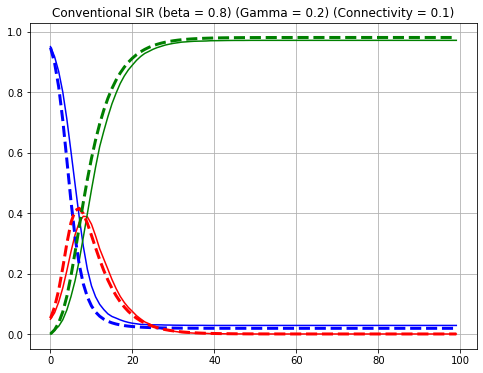

In [4]:
# ODE vs complete network (unweighted graph)

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = sir.initialise_weight(H, 1) # give every edge a weight of 1

s, i, r = smooth_basic(H, simulation_params)
S, I, R = sir.analytic_sol(H, simulation_params)
t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (8,6))
plt.title('Conventional SIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ')')

# numerical
plt.plot(t, s, label = 'susceptible', color = 'b')
plt.plot(t, i, label = 'infected', color = 'r')
plt.plot(t, r, label = 'recovered', color = 'g')

# analytic
plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 1)

plt.grid()


In [5]:

def weighted_beta(G, original_beta): # takes the orginal beta and returns an equivalent for a weighted network
    nodes = list(G.nodes)
    total = 0
    for node in nodes:
        connections = list(G.neighbors(node))
        subtotal = 0
        for connection in connections:
            subtotal += G[node][connection]['weight']
        total += (subtotal / len(connections))
    return original_beta * (total / len(G)) # need to divide by len(G) to give average over graph

def normalize_weights(G):
    # find the maximum weight
    max_weight = max([G[node1][node2]['weight'] for node1, node2 in G.edges])
    # normalize the weights
    for node1, node2 in G.edges:
        G[node1][node2]['weight'] /= max_weight
    return G

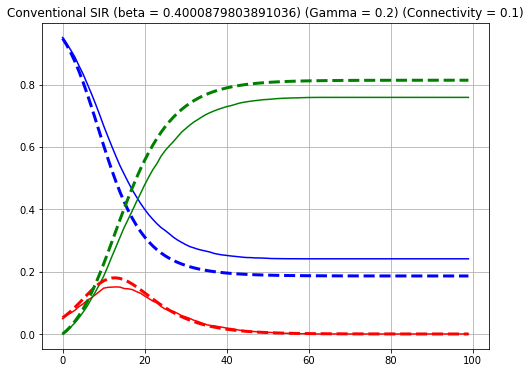

In [6]:
# ODE vs complete network (randomly weighted graph)

def initialise_weight_random(G): # Sets weight to all edges to 'weight'
    nodes = list(G.nodes)
    for node in nodes:
        connections = list(G.neighbors(node))
        for connection in connections:
            G[node][connection]['weight'] = random.random()
    return G

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = initialise_weight_random(H)
H = normalize_weights(H)

simulation_params['Beta'] = original_beta
s, i, r = smooth_basic(H, simulation_params)
simulation_params['Beta'] = weighted_beta(H, simulation_params['Beta'])
S, I, R = sir.analytic_sol(H, simulation_params)
t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (8,6))
plt.title('Conventional SIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ')')

# numerical
plt.plot(t, s, label = 'susceptible', color = 'b')
plt.plot(t, i, label = 'infected', color = 'r')
plt.plot(t, r, label = 'recovered', color = 'g')

# analytic
plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 1)

plt.grid()

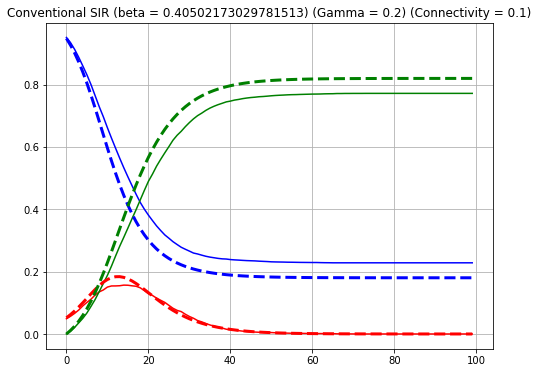

In [7]:
# ODE vs complete network (linear weighted graph)

def initialise_weight_linear(G): # Sets weight to all edges to 'weight'
    nodes = list(G.nodes)
    for node in nodes:
        connections = list(G.neighbors(node))
        for connection in connections:
            G[node][connection]['weight'] = ns.linear(random.random(), -1, 1)
    return G

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = initialise_weight_linear(H)
H = normalize_weights(H)

simulation_params['Beta'] = original_beta
s, i, r = smooth_basic(H, simulation_params)
simulation_params['Beta'] = weighted_beta(H, simulation_params['Beta'])
S, I, R = sir.analytic_sol(H, simulation_params)
t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (8,6))
plt.title('Conventional SIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ')')

# numerical
plt.plot(t, s, label = 'susceptible', color = 'b')
plt.plot(t, i, label = 'infected', color = 'r')
plt.plot(t, r, label = 'recovered', color = 'g')

# analytic
plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 1)

plt.grid()

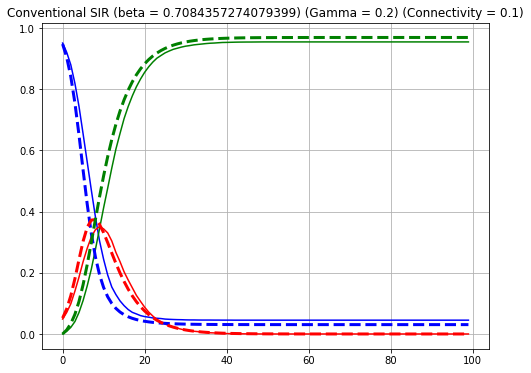

In [8]:
# ODE vs complete network (exponential weighted graph)

def initialise_weight_exponential(G): # Sets weight to all edges to 'weight'
    nodes = list(G.nodes)
    for node in nodes:
        connections = list(G.neighbors(node))
        for connection in connections:
            G[node][connection]['weight'] = ns.exponential(random.random(), .25, 4)
    return G

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = initialise_weight_exponential(H)
H = normalize_weights(H)

simulation_params['Beta'] = original_beta
s, i, r = smooth_basic(H, simulation_params)
simulation_params['Beta'] = weighted_beta(H, simulation_params['Beta'])
S, I, R = sir.analytic_sol(H, simulation_params)
t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (8,6))
plt.title('Conventional SIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ')')

# numerical
plt.plot(t, s, label = 'susceptible', color = 'b')
plt.plot(t, i, label = 'infected', color = 'r')
plt.plot(t, r, label = 'recovered', color = 'g')

# analytic
plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 1)

plt.grid()

In [9]:
# Checking if the randomly generated weights are behaving as predicted

test = []

for i in range(1000):
    test.append(ns.exponential(random.random(), -100, 1))

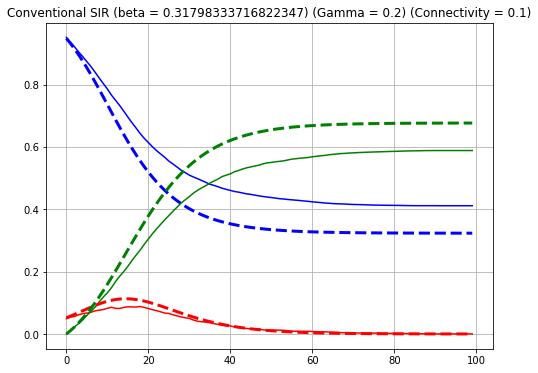

In [10]:
# ODE vs complete network (power weighted graph)

def initialise_weight_power(G): # Sets weight to all edges to 'weight'
    nodes = list(G.nodes)
    for node in nodes:
        connections = list(G.neighbors(node))
        for connection in connections:
            G[node][connection]['weight'] = ns.power(random.random(), 10, 1.5)
    return G

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = initialise_weight_power(H)
H = normalize_weights(H)

simulation_params['Beta'] = original_beta
s, i, r = smooth_basic(H, simulation_params)
simulation_params['Beta'] = weighted_beta(H, simulation_params['Beta'])
S, I, R = sir.analytic_sol(H, simulation_params)
t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (8,6))
plt.title('Conventional SIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ')')

# numerical
plt.plot(t, s, label = 'susceptible', color = 'b')
plt.plot(t, i, label = 'infected', color = 'r')
plt.plot(t, r, label = 'recovered', color = 'g')

# analytic
plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 1)

plt.grid()

# For higher +ve powers (about 4 or higher), a greater fraction of weights are close to zero which leads to a lack of spread of infection
# For -ve powers, there is increased infection seen as compared to the base case as on interval [0,1] the weight is greater than 1 which increases the chance of infection
# When modulating the coefficient of the power law we then begin to see lower infection as we would expect as the function is not always greater than 1


After trying these weighting schemes it is clear that there is some leeway within which the basic SIR spread on weighted networks will agree with the ODE solutions

I need to define some metric to calculate the similarity between the two sets of curves and use this to give a more rigourous range of weighting parameter values for which there is agreement with the ODE's

However, a conclusion is, generally, for weighted networks the ODE model is not a good fit (this should be clear anyway as what we are doing is effectively changing the beta value of the sysem - in this regard, does it make sense to always change the beta value to be less than the original or should we also acount for potential increases ... rather I think it makes more sense for the original beta value to be thought of as an average for the system and then weights that are added should be sampled from a normal distribution - this will retain characteristics [for certain beta values at least] but is this really what we mean by beta ... after doing a quick chatGPT, \beta is defined as: 'beta = lambda * sum(w_ij * A_ij) / k_i,' so in weighted network models what I think of beta is really lambda which gets scaled by the network structure to give the same overall beta parameter - I believe this is a requirement to keep consistent with the behaviour we expect from a disease. This is the next step forwards for our modelling).

After implementing the modulated beta value we will need implement n-SIR model

Additionally, the effects of decreasing the connectivity of the graph remains about the same despite changing the weights.

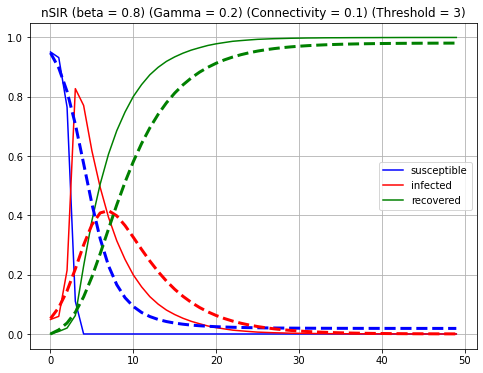

In [718]:
# nSIR on exponentially weighted network

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = initialise_weight_exponential(H)
H = normalize_weights(H)
H = sir.initialise_potential(H, simulation_params)
H = sir.initialise_status(H)

simulation_params['Threshold'] = 3
simulation_params['Runs'] = 100

simulation_params['Beta'] = original_beta
s, i, r = sir.smooth(H, simulation_params)
simulation_params['Gamma'] = 0.2

#simulation_params['Beta'] = weighted_beta(H, simulation_params['Beta'])
S, I, R = sir.analytic_sol(H, simulation_params)

t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (8,6))
plt.title('nSIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ') (Threshold = ' + str(simulation_params['Threshold']) + ')')

# numerical
plt.plot(t, s, label = 'susceptible', color = 'b')
plt.plot(t, i, label = 'infected', color = 'r')
plt.plot(t, r, label = 'recovered', color = 'g')

# analytic
plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 1)

plt.legend(loc = 'center right')
plt.grid()

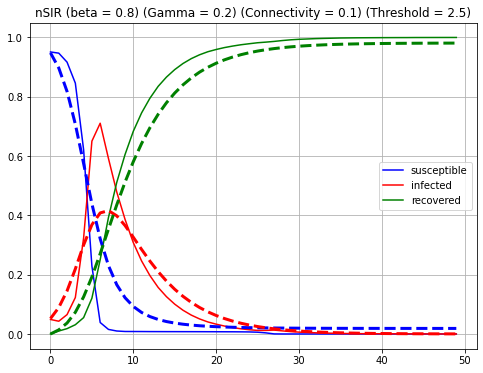

In [716]:
# nSIR on randomly weighted network

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = initialise_weight_random(H)
H = normalize_weights(H)
H = sir.initialise_potential(H, simulation_params)
H = sir.initialise_status(H)

simulation_params['Threshold'] = 2.5
simulation_params['Runs'] = 100
simulation_params['Beta'] = original_beta


s, i, r = sir.smooth(H, simulation_params)
#simulation_params['Beta'] = weighted_beta(H, simulation_params['Beta'])
S, I, R = sir.analytic_sol(H, simulation_params)
t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (8,6))
plt.title('nSIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ') (Threshold = ' + str(simulation_params['Threshold']) + ')')

# numerical
plt.plot(t, s, label = 'susceptible', color = 'b')
plt.plot(t, i, label = 'infected', color = 'r')
plt.plot(t, r, label = 'recovered', color = 'g')

# analytic
plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 1)

plt.legend(loc = 'center right')
plt.grid()

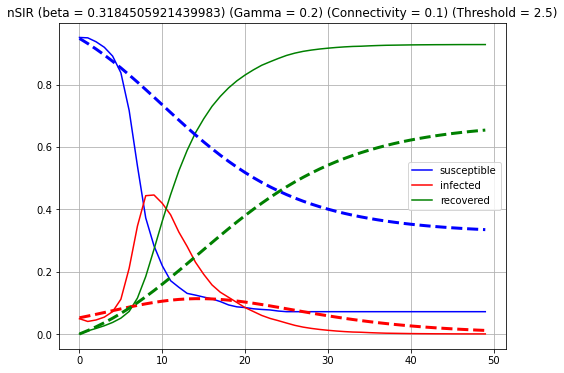

In [713]:
# nSIR on power law weighted network

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = initialise_weight_power(H)
H = normalize_weights(H)
H = sir.initialise_potential(H, simulation_params)
H = sir.initialise_status(H)

simulation_params['Threshold'] = 2.5
simulation_params['Runs'] = 100
simulation_params['Beta'] = original_beta
simulation_params['Gamma'] = 0.2

s, i, r = sir.smooth(H, simulation_params)

simulation_params['Beta'] = weighted_beta(H, simulation_params['Beta'])

S, I, R = sir.analytic_sol(H, simulation_params)
t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (8,6))
plt.title('nSIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ') (Threshold = ' + str(simulation_params['Threshold']) + ')')

# numerical
plt.plot(t, s, label = 'susceptible', color = 'b')
plt.plot(t, i, label = 'infected', color = 'r')
plt.plot(t, r, label = 'recovered', color = 'g')

# analytic
plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 1)

plt.legend(loc = 'center right')
plt.grid()

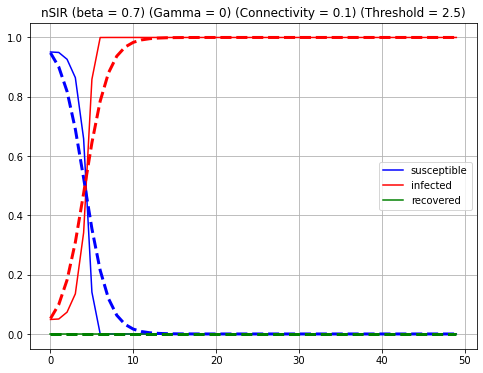

In [457]:
# nSIR on linear weighted network

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = initialise_weight_linear(H)
H = normalize_weights(H)
H = sir.initialise_potential(H, simulation_params)
H = sir.initialise_status(H)

simulation_params['Threshold'] = 2.5
simulation_params['Runs'] = 100
simulation_params['Beta'] = original_beta

s, i, r = sir.smooth(H, simulation_params)

#simulation_params['Beta'] = weighted_beta(H, simulation_params['Beta'])

S, I, R = sir.analytic_sol(H, simulation_params)
t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (8,6))
plt.title('nSIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ') (Threshold = ' + str(simulation_params['Threshold']) + ')')

# numerical
plt.plot(t, s, label = 'susceptible', color = 'b')
plt.plot(t, i, label = 'infected', color = 'r')
plt.plot(t, r, label = 'recovered', color = 'g')

# analytic
plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 1)

plt.legend(loc = 'center right')
plt.grid()


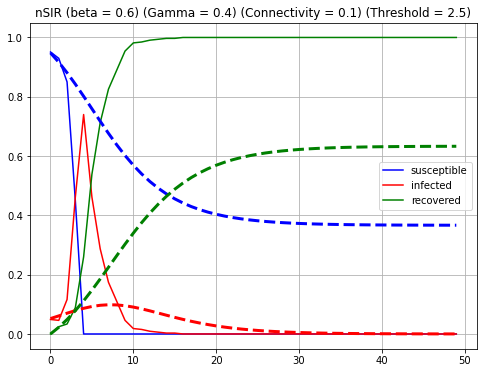

In [677]:
# nSIR on unweighted network

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = sir.initialise_weight(H, 1) # give every edge a weight of 1


H = sir.initialise_potential(H, simulation_params)
H = sir.initialise_status(H)

simulation_params['Beta'] = 0.6
simulation_params['Gamma'] = 0.4
simulation_params['Threshold'] = 2.5
simulation_params['Runs'] = 1

s, i, r = sir.smooth(H, simulation_params)
#simulation_params['Beta'] = weighted_beta(H, simulation_params['Beta'])
S, I, R = sir.analytic_sol(H, simulation_params)
t = np.arange(0, simulation_params['Time'])

plt.figure(figsize = (8,6))
plt.title('nSIR (beta = ' + str(simulation_params['Beta']) + ') (Gamma = ' + str(simulation_params['Gamma']) + ') (Connectivity = ' + str(connectivity) + ') (Threshold = ' + str(simulation_params['Threshold']) + ')')
# numerical
plt.plot(t, s, label = 'susceptible', color = 'b')
plt.plot(t, i, label = 'infected', color = 'r')
plt.plot(t, r, label = 'recovered', color = 'g')

# analytic
plt.plot(t, S, linewidth = 3, color = 'b', linestyle = 'dashed', alpha = 1)
plt.plot(t, I, linewidth = 3, color = 'r', linestyle = 'dashed', alpha = 1)
plt.plot(t, R, linewidth = 3,  color = 'g', linestyle = 'dashed', alpha = 1)

plt.legend(loc = 'center right')
plt.grid()

In [674]:
# find at which index the numerical solution stops changing
# slice both numerical and analytitcal and compare over this range

def check_steady(arr):
    # Iterate over the array comparing adjacent elements
    for i in range(len(arr) - 1):
        if abs(arr[i] - arr[i+1]) < 0.0001:
            steady =  True
            break
        else:
            steady = False      
    if steady:
        return steady, i+1
    else:
        return steady, i+2

def find_slice(curve1, curve2):
    inds = []
    inds.append(check_steady(curve1)[1])
    inds.append(check_steady(curve2)[1])
    return (max(inds))

def steady_slice(curve1, curve2):
    steady_index = find_slice(curve1, curve2)
    curve1 = curve1[0:steady_index]
    curve2 = curve2[0:steady_index]
    return curve1, curve2

# slicing numerical and analytical time series to compare only regions before steady state

s, S = steady_slice(s, S)
i, I = steady_slice(i, I)
r, R = steady_slice(r, R)



In [215]:
# From chatGPT, pearson correlation function to compare similarity of curves

import numpy as np
import matplotlib.pyplot as plt

# Compute the Pearson correlation coefficient between the curves
def pearson_correlation(curve1, curve2, plot = False):
    correlation = np.corrcoef(curve1, curve2)[0, 1]
    if plot:
        plt.plot(curve1, label='Numerical')
        plt.plot(curve2, label='Analytical')
        plt.title("Correlation coefficient:" + str(round(correlation, 3)))
        plt.legend()
        plt.show()
    return correlation

# Define two sample curves to compare
#curve1 = np.array([0, 10, 30, 50, 80, 110, 120, 130, 140, 150])
#curve2 = np.array([0, 5, 25, 45, 80, 100, 120, 130, 140, 150])
#pearson_correlation(curve1, curve2, 1)

/Users/ali/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/ali/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


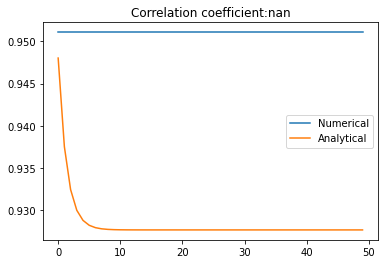

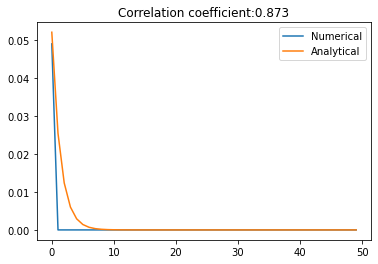

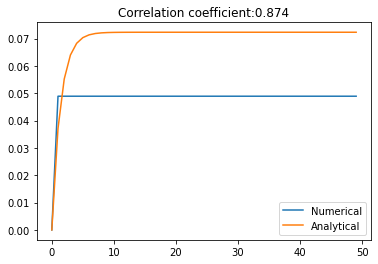

0.8736584428714047

In [492]:
pearson_correlation(s, S, 1)
pearson_correlation(i, I, 1)
pearson_correlation(r, R, 1)

In [487]:
import numpy as np
import matplotlib.pyplot as plt

def dynamic_time_warping(curve1, curve2): # Compute the similarity using dynamic time warping (DTW)
    n = len(curve1)
    m = len(curve2)
    dtw_matrix = np.zeros((n+1, m+1))
    dtw_matrix[1:, 0] = np.inf
    dtw_matrix[0, 1:] = np.inf
    for i in range(1, n+1):
        for j in range(1, m+1):
            cost = abs(curve1[i-1] - curve2[j-1])
            dtw_matrix[i, j] = cost + min(dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1])
    dtw_distance = dtw_matrix[-1, -1]
    return dtw_distance, dtw_matrix

def find_warping_path(curve1, curve2): # Plot the two curves and the warping path
    _, dtw_matrix = dynamic_time_warping(curve1, curve2)
    n = len(curve1)
    m = len(curve2)
    warping_path = []
    i, j = n, m
    while i > 0 and j > 0:
        warping_path.append((i-1, j-1))
        if dtw_matrix[i-1, j] == min(dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]):
            i -= 1
        elif dtw_matrix[i, j-1] == min(dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]):
            j -= 1
        else:
            i -= 1
            j -= 1
    warping_path.reverse()
    return warping_path

def plot_warping_path(curve1, curve2):
    plt.plot(curve1, label='Analytical')
    plt.plot(curve2, label='Numerical')
    warping_path = find_warping_path(curve1 ,curve2)
    for i, j in warping_path:
        plt.plot([i, j], [curve1[i], curve2[j]], alpha = 0.25, color ='b')
    plt.legend()
    plt.show()

def integrate_curve(curve):
    # Calculate the cumulative sum of the curve
    integrated_curve = np.cumsum(curve)
    # Return the final value
    return integrated_curve[-1]

def dtw_similarity(curve1, curve2, plot = False): # curve1 - numerical, curve2 - analytical
    analytical_integration = integrate_curve(curve2)
    if analytical_integration == 0:
        similarity = 1
    else:
        dtw_distance, _ = dynamic_time_warping(curve1, curve2)
        similarity = 1 - (dtw_distance / analytical_integration)
    if plot:
        plt.title("DTW similarity:" + str(round(similarity, 3)))
        plot_warping_path(curve1, curve2)
    return similarity

# Define two sample curves to compare
#curve1 = np.array([0, 10, 30, 50, 80, 110, 120, 130, 140, 150])
#curve2 = np.array([0, 5, 25, 45, 80, 100, 120, 130, 140, 150])
#dtw_similarity(curve1, curve2, 1)


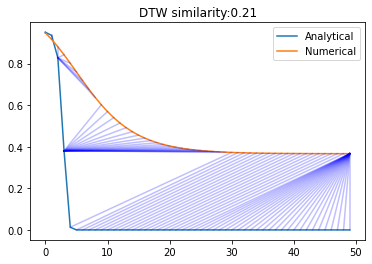

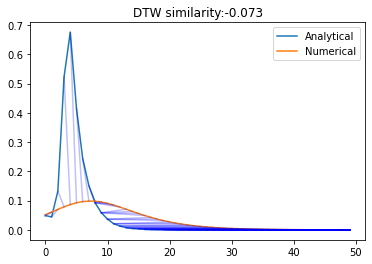

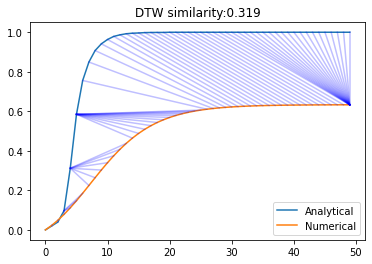

0.3194285322751601

In [676]:
dtw_similarity(s, S, 1)
dtw_similarity(i, I, 1)
dtw_similarity(r, R, 1)

In [731]:
# plotting similarity data on a heatmap
# not sure if axis are labelled correctly

import numpy as np
import matplotlib.pyplot as plt

def heatmap(data, title = 'placeholder'):
    # create heatmap
    fig, ax = plt.subplots()
    im = ax.imshow(data.T)
    # set axis labels
    ax.set_title(title)
    ax.set_xticks(np.arange(0, len(data)))
    ax.set_yticks(np.arange(0, len(data)))
    ax.set_xticklabels(np.arange(1, len(data)+ 1,1)/10)
    ax.set_yticklabels(np.arange(1, len(data)+1,1)/10)
    fig.gca().invert_yaxis()
    ax.set_ylabel('Beta')
    ax.set_xlabel('Gamma')
    # set colorbar
    ax.figure.colorbar(im, ax=ax)
    # show plot
    plt.show()

In [729]:
# beta, gamma to generate 2d heatmap

simulation_params = {}
simulation_params['Time'] = 50
simulation_params['Runs'] = 5 # low runs to enure doesn't take too long to run
simulation_params['Initial'] = 0.05
simulation_params['Threshold'] = 2.5

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
#H = sir.initialise_weight(H, 1) # give every edge a weight of 1
H = initialise_weight_linear(H)
H = normalize_weights(H)
H = sir.initialise_potential(H, simulation_params)
H = sir.initialise_status(H)

t = np.arange(0, simulation_params['Time'])

s_matrix = []
i_matrix = []
r_matrix = []

for j in range(1,11):
    print(j)
    simulation_params['Beta'] = j/10
    #simulation_params['Beta'] = weighted_beta(H, simulation_params['Beta'])
    s_matrix.append([])
    i_matrix.append([])
    r_matrix.append([])
    for k in range(1, 11):
        simulation_params['Gamma'] = k/10
        S, I, R = sir.analytic_sol(H, simulation_params)
        s, i, r = sir.smooth(H, simulation_params)
        
        s, S = steady_slice(s, S)
        i, I = steady_slice(i, I)
        r, R = steady_slice(r, R)
        
        s_matrix[-1].append(dtw_similarity(s, S, 0))
        i_matrix[-1].append(dtw_similarity(i, I, 0))
        r_matrix[-1].append(dtw_similarity(r, R, 0))
        

1
2
3
4
5
6
7
8
9
10


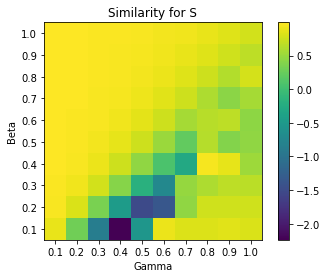

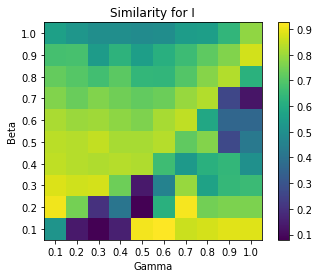

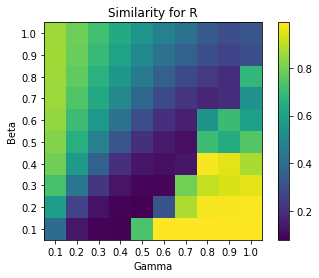

In [732]:
heatmap(np.array(s_matrix), 'Similarity for S')
heatmap(np.array(i_matrix), 'Similarity for I')
heatmap(np.array(r_matrix), 'Similarity for R')

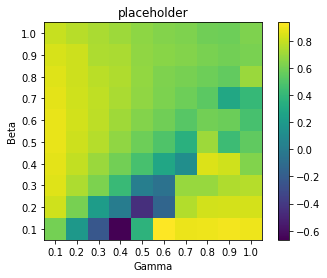

0.937627943561823


In [735]:
overall_similarity = np.array(s_matrix) + np.array(i_matrix) + np.array(r_matrix)
overall_similarity /= 3
heatmap(overall_similarity)
print(np.amax(overall_similarity))  

Max similarity values seen:

- 0.9206843353186623
- 0.8831564691975103
- 0.9161192815500212
- 0.8775065408861421
- 0.885743494827803

with this we can, in the unweighted beta regime, our similarity is appox 88.5%

However, in the weighted beta regime - there will be no difference as were using an unweighted graph in this case. So will need to test for a weighted graph ...

For an exponentially weighted graph we see 89.5% when using weighted beta.
without using weighted beta we see 88.2%

For a power law weighted graph we see 92.3% when using weighted beta.
wihtout using weighted beta we see 91.5%

For linear weighting:
 - weighted beta: 91.5%
 - unweighted beta: 93.7%

Therefore, there is always some small apreciable benefit to using weighted beta -  this is actually a finding (ALHAMDULLILAH)

PROBLEM: linear weighting performs worse when using weighted beta!!!
    -> can justify as this is not typical of real weighted networks - > SOLVED

In [734]:
import numpy as np

# create 2D array
arr = overall_similarity

# find index of highest value
min_index = np.unravel_index(arr.argmin(), arr.shape)
max_index = np.unravel_index(arr.argmax(), arr.shape)

# print index of highest value
print(min_index)
print(max_index)

(3, 0)
(5, 0)


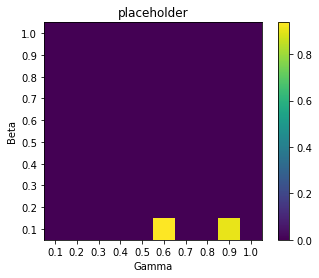

In [743]:
# This sets the values of heatmap to 0 once determined to be below threshold.as_integer_ratio
# making the same profile irrecoverable

import numpy as np

# create 2D array
arr = overall_similarity

# set threshold
threshold = 0.9

# find values below threshold and set them to 0
arr[arr < threshold] = 0

# print updated array

heatmap(arr)


In [639]:
# beta, gamma, threshold for 3d scatter heatmap

simulation_params = {}
simulation_params['Time'] = 50
simulation_params['Runs'] = 1 # low runs to enure doesn't take too long to run
simulation_params['Initial'] = 0.05
simulation_params['Threshold'] = 2.5

H = nx.fast_gnp_random_graph(N, connectivity) # Complete graph
H = sir.initialise_weight(H, 1) # give every edge a weight of 1
H = sir.initialise_potential(H, simulation_params)
H = sir.initialise_status(H)

t = np.arange(0, simulation_params['Time'])

s_matrix = []
i_matrix = []
r_matrix = []

for j in range(1,11):
    print(j)
    simulation_params['Beta'] = j/10
    s_matrix.append([])
    i_matrix.append([])
    r_matrix.append([])
    for k in range(1, 11):
        simulation_params['Gamma'] = k/10
        s_matrix[-1].append([])
        i_matrix[-1].append([])
        r_matrix[-1].append([])
        for l in range(1, 16):
            simulation_params['Threshold'] = k*0.5
            S, I, R = sir.analytic_sol(H, simulation_params)
            s, i, r = sir.smooth(H, simulation_params)
            
            s, S = steady_slice(s, S)
            i, I = steady_slice(i, I)
            r, R = steady_slice(r, R)
            
            s_matrix[-1][-1].append(dtw_similarity(s, S, 0))
            i_matrix[-1][-1].append(dtw_similarity(i, I, 0))
            r_matrix[-1][-1].append(dtw_similarity(r, R, 0))
        

1
2
3
4
5
6
7
8
9
10


In [640]:
overall_similarity = np.array(s_matrix) + np.array(i_matrix) + np.array(r_matrix)
overall_similarity /= 3

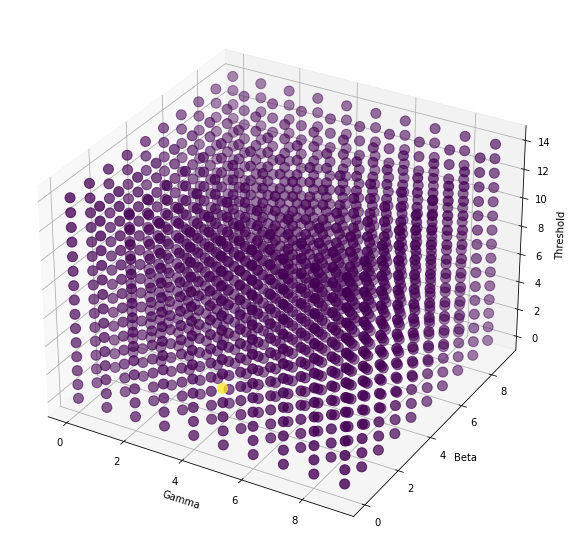

In [661]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# create a 3D array with random data
data = overall_similarity

# create a 3D plot
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# plot the data
x, y, z = np.meshgrid(np.arange(10), np.arange(10), np.arange(15))
ax.scatter(x, y, z, s = 100, c=data.flatten())

# set the labels
ax.set_xlabel('Gamma')
ax.set_ylabel('Beta')
ax.set_zlabel('Threshold')

# show the plot
plt.show()


In [647]:
np.amax(overall_similarity)


0.8904518763560513

In [659]:
import numpy as np

# create a 3D array with random data
data = overall_similarity

# define the threshold
threshold = 0.89

# find all values below the threshold
mask = data < threshold

# set those values to 0
data[mask] = 0


In [648]:
import numpy as np

# create a 3D array with random data
data = overall_similarity

# find the index of the maximum value in the array
max_index = np.unravel_index(np.argmax(data), data.shape)

print("The index of the maximum value in the array is:", max_index)


The index of the maximum value in the array is: (0, 5, 4)


from big brain studies, we have shown that best fit is for beta = 0.6, gamma = 0.1, threshold = 2.5